In [5]:
import cv2
from skimage.filters import threshold_adaptive
from skimage.transform import radon
import imutils
import argparse
import numpy as np
import scipy.signal
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [6]:
def auto_canny(image, sigma=0.33):
    median = np.median(image)
    lower_threshold = int(max(0, 1.0 - sigma) * median)
    upper_threshold = int(min(255, 1.0 + sigma) * median)
    edged = cv2.Canny(image, lower_threshold, upper_threshold)
    return edged

In [7]:
image = cv2.imread('test_whiteboards/cellphone_samples/whiteboard_skewed.jpg')

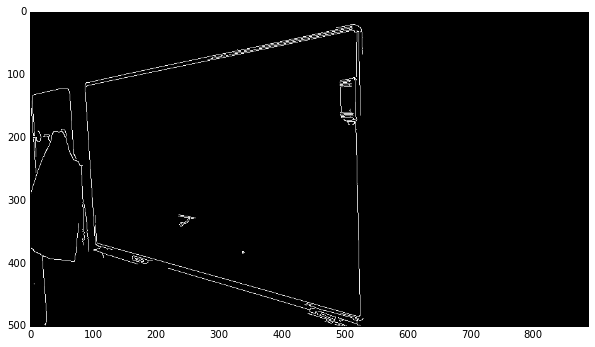

In [8]:
size_for_edge = 500
ratio = image.shape[0] / size_for_edge
image_resized = imutils.resize(image, height=size_for_edge)

gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 1)
edged_auto = auto_canny(gray, sigma=0.5)
cv2.imshow("auto canny", edged_auto)
(_, cnts, _) = cv2.findContours(edged_auto.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_TC89_KCOS)
plt.imshow(edged_auto,cmap=plt.cm.Greys_r)

In [9]:
sinogram = radon(edged_auto, circle=False)

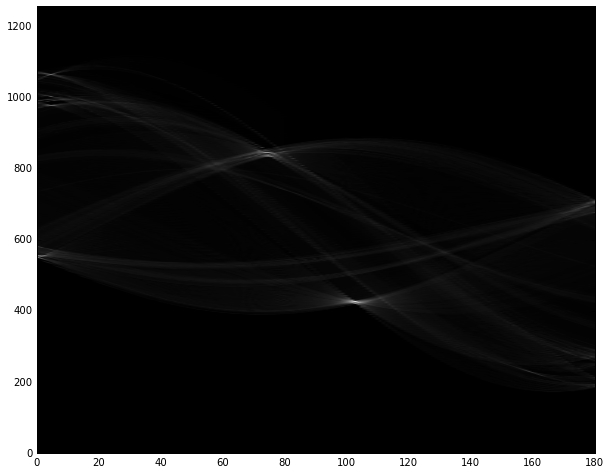

In [10]:
plt.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

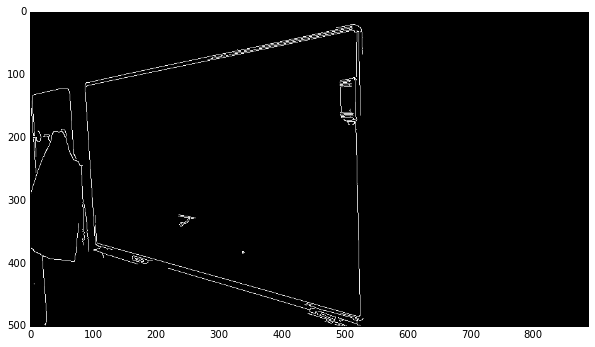

In [11]:
plt.imshow(edged_auto, cmap=plt.cm.Greys_r)

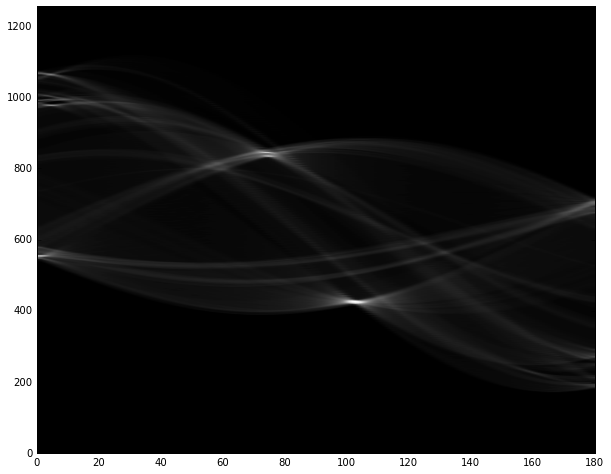

In [12]:
sino_blurred = cv2.GaussianBlur(sinogram, (5, 5), 1)
plt.imshow(sino_blurred, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

In [13]:
scipy.signal.argrelmax(sino_blurred, order=5)

(array([ 154,  154,  154, ..., 1082, 1082, 1082]),
 array([ 21,  22,  23, ..., 166, 167, 168]))

In [14]:
grey_show = lambda img: plt.imshow(img, cmap=plt.cm.Greys_r, aspect='auto')
def dilate(A, width):
    x_l = A.shape[0]
    y_l = A.shape[1]
    B = A.copy()
    for ii in range(x_l):
        for jj in range(y_l):
            xrange_l = max(ii-width,0)
            xrange_u = min(ii+width,x_l)
            yrange_l = max(jj-width,0)
            yrange_u = min(jj+width,y_l)
            B[ii,jj] = np.amax(A[xrange_l:xrange_u, yrange_l:yrange_u])
    return B

In [15]:
sino_flat = dilate(sino_blurred,5)

In [16]:
print(sino_flat[851,96])
print(sino_blurred[851,96])

5572.6172451
363.539638604


In [17]:
candidates = np.transpose(np.nonzero((sino_flat==sino_blurred)*sinogram))
vals = [sino_blurred[x,y] for (x,y) in candidates]
best_candidates = np.argsort(vals)[-10:]

In [18]:
for x in best_candidates:
    (x,y) = candidates[x,:]
    print(x, y , sino_blurred[x,y])

986 179 8233.22676197
444 58 9644.41706402
265 8 10706.0899048
552 179 12772.1785788
194 4 14849.6995159
280 4 18193.017444
413 73 24376.1226137
423 74 25075.2318897
703 0 26457.7229413
830 102 36051.6514747


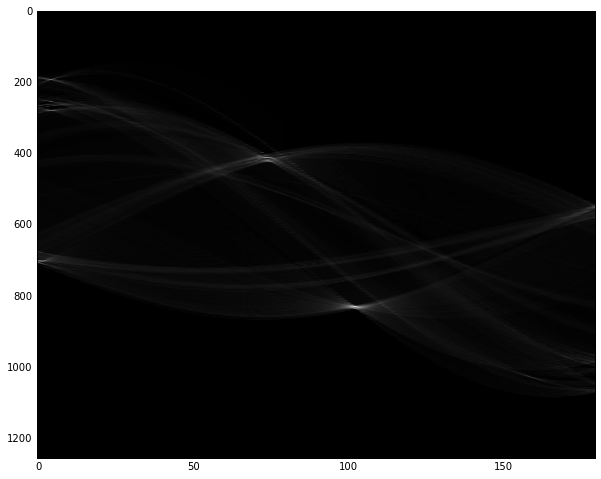

In [19]:
grey_show(sinogram)

In [20]:
def sino_to_point(angle,offset,shape):
    middle = np.array([shape[1]/2, shape[0]/2])
    max_offset = np.sqrt(2) * np.max(shape)
    offset_to_middle = offset - (max_offset/2)
    phi = angle / 180 * np.pi
    offset_dir_x = np.cos(phi)
    offset_dir_y = -np.sin(phi)
    offset_v = np.array([offset_dir_x * offset_to_middle, offset_dir_y * offset_to_middle])
    point_of_line = middle + offset_v
    return [point_of_line, point_of_line + 20 * np.array([offset_dir_y, -offset_dir_x])]

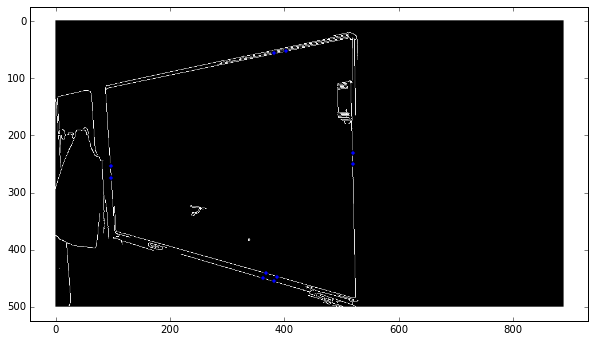

In [21]:
plt.imshow(edged_auto, cmap=plt.cm.Greys_r)
for ii in range(5):
    (offset, angle) = candidates[best_candidates[-1-ii],:]
    (point, point_v) = sino_to_point(angle, offset, edged_auto.shape)
    plt.scatter([point[0], point_v[0]],[point[1], point_v[1]])

In [111]:
# How to find the corners of a rectangle?
# Idea: find two opposite sides first.
#       These can be defined in the following way: When starting from their intersection AB, the
#       intersections AC and AD need to have the same distance-order as BC and BD (or the triplet (AB,AC,AD)
#       must have the same order as the triplet (AB,BC,BD)).
def find_intersection(line1, line2,debug=False):
    #Find the intersection point between two lines. The lines are given by a pair of points on them.
    #Needs special cases that are missing! (x[0]==0,y[1]==0)
    x = line1[1] - line1[0]
    y = line2[1] - line2[0]
    c = line2[0] - line1[0]
    if(min(abs(x[0]),abs(y[1])) < min(abs(x[1]),abs(y[0]))):
        # To avoid divide by zero error, we switch the two lines
        return find_intersection(line2, line1)
    if debug:
        print(x,y,c)
    # a * x + b * y = c
    # a = (c[0] - b * y[0]) / x[0]
    # b = (c[1] - a * x[1]) / y[1]
    # b = (c[1] - (c[0] - b * y[0]) / x[0] * x[1]) / y[1]
    # b * (1 - y[0] / x[0] * x[1] / y[1]) = c[1] / y[1] - c[0] * x[1] / x[0] / y[1]
    b = (c[1] / y[1] - c[0] * x[1] / x[0] / y[1]) / (1 - y[0] / x[0] * x[1] / y[1])
    a = (c[0] - b * y[0]) / x[0]
    return np.array(line1[0] + a * (line1[1] - line1[0]))

def find_intersections(line1, otherlines):
    return [find_intersection(line1, ol) for ol in otherlines]

def order_points(points):
    """Orders points (given as list of coordinate tuples) that lie on a line.
    Tries to preserve order. Gives reordering as tuple of indices."""
    line_vec = points[1] - points[0]
    origin = points[0]
    distances = [np.dot(p - origin, line_vec) for p in points ]
    return np.argsort(distances)
    
def get_corners(lines):
    #Find the corners of a rectangle given by four lines. Probably crashes if two lines are exactly parallel.
    l = lines[0]
    otherlines = lines[1:]
    for (ii,ol) in enumerate(otherlines):
        inter = find_intersection(l, ol)
        rest = otherlines.copy()
        del rest[ii]
        inters1 = [inter] + find_intersections(l, rest)
        inters2 = [inter] + find_intersections(ol, rest)
        if np.all(order_points(inters1) == order_points(inters2)):
            # The two lines are opposite in the rectangle
            break;
    lines = [l, rest[0], ol, rest[1]]
    print(find_intersection(lines[1],lines[2],debug=True))
    corners = [find_intersection(lines[ii], lines[(ii+1)%4]) for ii in range(4)]
    return (corners, lines)

[ 519.08917831  484.70008761]
[array([ 519.08917831,   27.43533168]), array([ 519.08917831,  484.70008761]), array([ 103.3146705 ,  365.47866598]), array([  86.11189358,  119.4674946 ])]


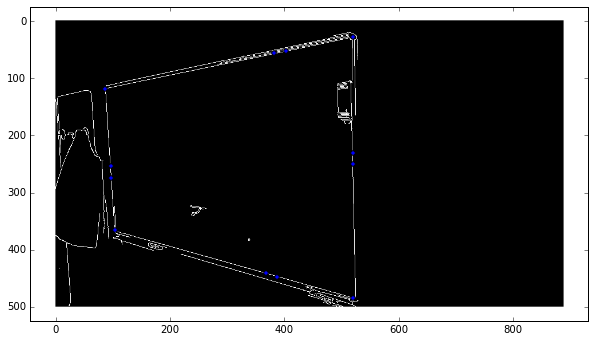

In [115]:
#Lets filter the candidate lines to get some that we can use as blackboard outlines
cands = [candidates[best_candidates[-ii],:] for ii in [1,2,3,5] ]
ls = [sino_to_point(angle,offset, edged_auto.shape) for (offset, angle) in cands]
inters = [find_intersection(ls[0], l) for l in ls[1:]]
plt.imshow(edged_auto, cmap=plt.cm.Greys_r)
for l in ls:
    plt.scatter([l[0][0], l[1][0]],[l[0][1], l[1][1]])
max_x = edged_auto.shape[0]
max_y = edged_auto.shape[1]
(corners, ordered_ls) = get_corners(ls)
print(corners)
for c in corners:
    plt.scatter([c[0]], [c[1]])
for inter in inters:
    if inter[0] > 0 and inter[0] < max_y and inter[1] > 0 and inter[1] < max_x:
        pass
        #plt.scatter([inter[0],],[inter[1],])